In [ ]:
pip install xgboost

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.compose import ColumnTransformer
import xgboost as xgb
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', None)


In [2]:
olist_df = pd.read_csv("olist_orders_dataset.csv")
olist_customer_df = pd.read_csv("olist_customers_dataset.csv", encoding="latin1")
olist_seller_df = pd.read_csv("olist_sellers_dataset.csv", encoding="latin1")
olist_product_df = pd.read_csv("olist_products_dataset.csv", encoding="latin1")
olist_order_items_df = pd.read_csv("olist_order_items_dataset.csv", encoding="latin1")
olist_order_payments_df = pd.read_csv("olist_order_payments_dataset.csv", encoding="latin1")  

# Data

In [ ]:
# %ls *.csv

In [ ]:
olist_product_df.info()

In [ ]:
olist_seller_df.info()

In [ ]:
olist_order_items_df.info()

In [ ]:
olist_df.info()

In [ ]:
olist_customer_df.info()

# Data Cleaning

In [6]:
olist_order_items_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112650 entries, 0 to 112649
Data columns (total 7 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   order_id             112650 non-null  object 
 1   order_item_id        112650 non-null  int64  
 2   product_id           112650 non-null  object 
 3   seller_id            112650 non-null  object 
 4   shipping_limit_date  112650 non-null  object 
 5   price                112650 non-null  float64
 6   freight_value        112650 non-null  float64
dtypes: float64(2), int64(1), object(4)
memory usage: 6.0+ MB


In [8]:
olist_df["order_purchase_timestamp"] = pd.to_datetime(olist_df["order_purchase_timestamp"])
olist_df["order_approved_at"] = pd.to_datetime(olist_df["order_approved_at"]).dt.date
olist_df["order_delivered_carrier_date"] = pd.to_datetime(olist_df["order_delivered_carrier_date"])
olist_df["order_delivered_customer_date"] = pd.to_datetime(olist_df["order_delivered_customer_date"]).dt.date
olist_df["order_estimated_delivery_date"] = pd.to_datetime(olist_df["order_estimated_delivery_date"])

olist_df["order_date"] = olist_df["order_purchase_timestamp"].dt.date
olist_df["o_year"] = olist_df["order_purchase_timestamp"].dt.year
olist_df["o_month"] = olist_df["order_purchase_timestamp"].dt.month
olist_df["o_weekday"] = olist_df["order_purchase_timestamp"].dt.weekday
olist_df["is_weekend"] = olist_df["o_weekday"].apply(lambda x: 1 if x >= 5 else 0)

olist_df["o_season"] = olist_df["o_month"].map({
    12: "summer", 1: "summer", 2: "summer",
    3: "autumn", 4: "autumn", 5: "autumn",
    6: "winter", 7: "winter", 8: "winter",
    9: "spring", 10: "spring", 11: "spring"
})

olist_df['order_date'] = pd.to_datetime(olist_df['order_date'])
olist_df['order_delivered_customer_date'] = pd.to_datetime(olist_df['order_delivered_customer_date'])

olist_df['delivery_after(days)'] = (olist_df['order_delivered_customer_date'] - olist_df['order_date']).dt.days

olist_df['estimated_days'] = olist_df['order_estimated_delivery_date'] - olist_df['order_purchase_timestamp']
olist_df['estimated_days'] = olist_df['estimated_days'].dt.days

# olist_df['estimated'] = olist_df['estimated_days']
olist_df['days'] = 'days'

olist_df.drop(columns=['days'], inplace=True)

olist_df.head()



# Print the DataFrame to check the results
# print(olist_df[['order_date', 'order_delivered_customer_date', 'delivery_after(days)']
olist_df.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_date,o_year,o_month,o_weekday,is_weekend,o_season,delivery_after(days),estimated_days
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02,2017-10-04 19:55:00,2017-10-10,2017-10-18,2017-10-02,2017,10,0,0,spring,8.0,15
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26,2018-07-26 14:31:00,2018-08-07,2018-08-13,2018-07-24,2018,7,1,0,winter,14.0,19
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08,2018-08-08 13:50:00,2018-08-17,2018-09-04,2018-08-08,2018,8,2,0,winter,9.0,26
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18,2017-11-22 13:39:59,2017-12-02,2017-12-15,2017-11-18,2017,11,5,1,spring,14.0,26
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13,2018-02-14 19:46:34,2018-02-16,2018-02-26,2018-02-13,2018,2,1,0,summer,3.0,12


In [9]:
customer_orders = olist_df.groupby("customer_id").size().reset_index(name="num_past_orders")

In [10]:
sellers_per_product = olist_order_items_df.groupby("product_id")["seller_id"].nunique().reset_index(name="num_sellers")

In [12]:
olist_order_items_df["total_price"] = (olist_order_items_df["price"]+ olist_order_items_df["freight_value"])* olist_order_items_df["order_item_id"]

In [14]:
order_features = olist_order_items_df.groupby("order_id").agg({"order_item_id": "count",
                                                               "total_price": "sum"}).reset_index()
order_features.rename(columns={"order_item_id": "num_items", "total_price": "order_total_price"}, inplace=True)
olist_df

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_date,o_year,o_month,o_weekday,is_weekend,o_season,delivery_after(days),estimated_days
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02,2017-10-04 19:55:00,2017-10-10,2017-10-18,2017-10-02,2017,10,0,0,spring,8.0,15
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26,2018-07-26 14:31:00,2018-08-07,2018-08-13,2018-07-24,2018,7,1,0,winter,14.0,19
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08,2018-08-08 13:50:00,2018-08-17,2018-09-04,2018-08-08,2018,8,2,0,winter,9.0,26
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18,2017-11-22 13:39:59,2017-12-02,2017-12-15,2017-11-18,2017,11,5,1,spring,14.0,26
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13,2018-02-14 19:46:34,2018-02-16,2018-02-26,2018-02-13,2018,2,1,0,summer,3.0,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99436,9c5dedf39a927c1b2549525ed64a053c,39bd1228ee8140590ac3aca26f2dfe00,delivered,2017-03-09 09:54:05,2017-03-09,2017-03-10 11:18:03,2017-03-17,2017-03-28,2017-03-09,2017,3,3,0,autumn,8.0,18
99437,63943bddc261676b46f01ca7ac2f7bd8,1fca14ff2861355f6e5f14306ff977a7,delivered,2018-02-06 12:58:58,2018-02-06,2018-02-07 23:22:42,2018-02-28,2018-03-02,2018-02-06,2018,2,1,0,summer,22.0,23
99438,83c1379a015df1e13d02aae0204711ab,1aa71eb042121263aafbe80c1b562c9c,delivered,2017-08-27 14:46:43,2017-08-27,2017-08-28 20:52:26,2017-09-21,2017-09-27,2017-08-27,2017,8,6,1,winter,25.0,30
99439,11c177c8e97725db2631073c19f07b62,b331b74b18dc79bcdf6532d51e1637c1,delivered,2018-01-08 21:28:27,2018-01-08,2018-01-12 15:35:03,2018-01-25,2018-02-15,2018-01-08,2018,1,0,0,summer,17.0,37


In [18]:
olist_df = olist_df.merge(olist_customer_df, on="customer_id") \
             .merge(olist_order_items_df, on="order_id") \
             .merge(olist_product_df, on="product_id") \
             .merge(sellers_per_product, on="product_id") \
             .merge(order_features, on="order_id") \
             .merge(customer_orders, on="customer_id")
# olist_df = olist_df.merge(item_df, on='order_id', how='left')
# olist_df = olist_df.merge(products_df, on='product_id', how='outer')
# olist_df = olist_df.merge(customers_df, on='customer_id', how='outer')
olist_df = olist_df.merge(olist_seller_df, on='seller_id', how='outer')
# print(olist_df.shape)

In [19]:
olist_df

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_date,o_year,o_month,o_weekday,is_weekend,o_season,delivery_after(days),estimated_days,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,total_price,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,num_sellers,num_items,order_total_price,num_past_orders,seller_zip_code_prefix,seller_city,seller_state
0,9dc8d1a6f16f1b89874c29c9d8d30447,d9442164acf4b03109425633efaa0cfc,delivered,2017-10-12 13:33:22,2017-10-12,2017-10-17 15:42:42,2017-10-24,2017-11-06,2017-10-12,2017,10,3,0,spring,12.0,24,9915eb9f74b6c11aaf04833f65b00e93,38600,paracatu,MG,1,a2ff5a97bf95719e38ea2e3b4105bce8,0015a82c2db000af6aaaf3ae2ecb0532,2017-10-18 14:49:22,895.00,21.02,916.02,eletroportateis,40.0,849.0,2.0,11800.0,40.0,43.0,36.0,1,1,916.02,1,9080,santo andre,SP
1,d455a8cb295653b55abda06d434ab492,944b72539d7e1f7f7fc6e46639ef1fe3,delivered,2017-09-26 22:17:05,2017-09-27,2017-09-29 15:53:03,2017-10-07,2017-10-30,2017-09-26,2017,9,1,0,spring,11.0,33,3c7e305796add66698959fc7ad176f6b,87502,umuarama,PR,1,a2ff5a97bf95719e38ea2e3b4105bce8,0015a82c2db000af6aaaf3ae2ecb0532,2017-10-12 22:24:16,895.00,21.02,916.02,eletroportateis,40.0,849.0,2.0,11800.0,40.0,43.0,36.0,1,1,916.02,1,9080,santo andre,SP
2,7f39ba4c9052be115350065d07583cac,d7fc82cbeafea77bd0a8fbbf6296e387,delivered,2017-10-18 08:16:34,2017-10-18,2017-10-20 14:29:01,2017-10-27,2017-11-09,2017-10-18,2017,10,2,0,spring,9.0,21,9de5797cddb92598755a0f76383ddbbb,35490,entre rios de minas,MG,1,a2ff5a97bf95719e38ea2e3b4105bce8,0015a82c2db000af6aaaf3ae2ecb0532,2017-10-24 23:56:20,895.00,21.02,916.02,eletroportateis,40.0,849.0,2.0,11800.0,40.0,43.0,36.0,1,1,916.02,1,9080,santo andre,SP
3,e6ce16cb79ec1d90b1da9085a6118aeb,494dded5b201313c64ed7f100595b95c,delivered,2017-05-16 19:41:10,2017-05-16,2017-05-18 11:40:40,2017-05-29,2017-06-07,2017-05-16,2017,5,1,0,autumn,13.0,21,f2a85dec752b8517b5e58a06ff3cd937,20780,rio de janeiro,RJ,1,08574b074924071f4e201e151b152b4e,001cca7ae9ae17fb1caed9dfb1094831,2017-05-22 19:50:18,99.00,30.53,129.53,ferramentas_jardim,36.0,450.0,1.0,9000.0,42.0,12.0,39.0,1,2,388.59,1,29156,cariacica,ES
4,e6ce16cb79ec1d90b1da9085a6118aeb,494dded5b201313c64ed7f100595b95c,delivered,2017-05-16 19:41:10,2017-05-16,2017-05-18 11:40:40,2017-05-29,2017-06-07,2017-05-16,2017,5,1,0,autumn,13.0,21,f2a85dec752b8517b5e58a06ff3cd937,20780,rio de janeiro,RJ,2,08574b074924071f4e201e151b152b4e,001cca7ae9ae17fb1caed9dfb1094831,2017-05-22 19:50:18,99.00,30.53,259.06,ferramentas_jardim,36.0,450.0,1.0,9000.0,42.0,12.0,39.0,1,2,388.59,1,29156,cariacica,ES
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112645,81251f18621a822ad5b09593dfee4fc9,ae4dce7235e0aac52e4b82c54f7b18de,delivered,2017-01-21 14:17:21,2017-01-21,2017-01-25 16:51:53,2017-01-27,2017-03-16,2017-01-21,2017,1,5,1,summer,6.0,53,f992b70fb02cdfadc277f493997515b7,13660,porto ferreira,SP,1,c4b925e40f11289063a854c47aaef129,ffff564a4f9085cd26170f4732393726,2017-01-31 14:17:21,11.50,10.96,22.46,eletronicos,39.0,286.0,3.0,100.0,20.0,20.0,20.0,1,1,22.46,1,13070,campinas,SP
112646,021d08e4057e5b6414c8d2f69f4f72a0,7470a1ddb5f78a811fbef15b2556781b,delivered,2016-10-07 17:37:49,2016-10-07,2016-10-25 12:05:58,2016-10-30,2016-12-19,2016-10-07,2016,10,4,0,spring,23.0,72,5d2db05a565eda438cf5069b7be6b1bb,35400,ouro preto,MG,1,a819714dd23a6ac18b1be2b13686017b,ffff564a4f9085cd26170f4732393726,2016-10-17 19:01:41,51.50,14.53,66.03,automotivo,54.0,393.0,2.0,100.0,17.0,17.0,17.0,1,1,66.03,1,13070,campinas,SP
112647,2fbb05b3ee700e1897b9fa501e416005,b85708f7ff9d1b6fce163c71086084f9,delivered,2016-10

In [20]:
# olist_df.to_csv("Olist_al.csv", index=False)
olist_df.shape

(112650, 42)

In [21]:
# olist_df = olist_df.merge(olist_customer_df[['customer_id', 'customer_zip_code_prefix']], on='customer_id', how='left')
# olist_order_items_df = olist_order_items_df.merge(olist_seller_df[['seller_id ', 'seller_state']], on='seller_id ', how='left')
# olist_order_items_df = olist_order_items_df.merge(olist_seller_df[['product_id', 'product_category_name']], on='product_id', how='left')

In [22]:
olist_df.head(2)

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_date,o_year,o_month,o_weekday,is_weekend,o_season,delivery_after(days),estimated_days,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,total_price,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,num_sellers,num_items,order_total_price,num_past_orders,seller_zip_code_prefix,seller_city,seller_state
0,9dc8d1a6f16f1b89874c29c9d8d30447,d9442164acf4b03109425633efaa0cfc,delivered,2017-10-12 13:33:22,2017-10-12,2017-10-17 15:42:42,2017-10-24,2017-11-06,2017-10-12,2017,10,3,0,spring,12.0,24,9915eb9f74b6c11aaf04833f65b00e93,38600,paracatu,MG,1,a2ff5a97bf95719e38ea2e3b4105bce8,0015a82c2db000af6aaaf3ae2ecb0532,2017-10-18 14:49:22,895.0,21.02,916.02,eletroportateis,40.0,849.0,2.0,11800.0,40.0,43.0,36.0,1,1,916.02,1,9080,santo andre,SP
1,d455a8cb295653b55abda06d434ab492,944b72539d7e1f7f7fc6e46639ef1fe3,delivered,2017-09-26 22:17:05,2017-09-27,2017-09-29 15:53:03,2017-10-07,2017-10-30,2017-09-26,2017,9,1,0,spring,11.0,33,3c7e305796add66698959fc7ad176f6b,87502,umuarama,PR,1,a2ff5a97bf95719e38ea2e3b4105bce8,0015a82c2db000af6aaaf3ae2ecb0532,2017-10-12 22:24:16,895.0,21.02,916.02,eletroportateis,40.0,849.0,2.0,11800.0,40.0,43.0,36.0,1,1,916.02,1,9080,santo andre,SP


In [28]:
# olist_order_items_df.head()

In [30]:
# olist_df.head(2)

In [31]:
# Step 1: Ensure the column is in datetime format
# olist_df['order_purchase_timestamp'] = pd.to_datetime(olist_df['order_purchase_timestamp'])

# Step 2: Extract the time only
olist_df['order_purchase_time'] = olist_df['order_purchase_timestamp'].dt.time


In [33]:
olist_df.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_date,o_year,o_month,o_weekday,is_weekend,o_season,delivery_after(days),estimated_days,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,total_price,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,num_sellers,num_items,order_total_price,num_past_orders,seller_zip_code_prefix,seller_city,seller_state,order_purchase_time
0,9dc8d1a6f16f1b89874c29c9d8d30447,d9442164acf4b03109425633efaa0cfc,delivered,2017-10-12 13:33:22,2017-10-12,2017-10-17 15:42:42,2017-10-24,2017-11-06,2017-10-12,2017,10,3,0,spring,12.0,24,9915eb9f74b6c11aaf04833f65b00e93,38600,paracatu,MG,1,a2ff5a97bf95719e38ea2e3b4105bce8,0015a82c2db000af6aaaf3ae2ecb0532,2017-10-18 14:49:22,895.0,21.02,916.02,eletroportateis,40.0,849.0,2.0,11800.0,40.0,43.0,36.0,1,1,916.02,1,9080,santo andre,SP,13:33:22
1,d455a8cb295653b55abda06d434ab492,944b72539d7e1f7f7fc6e46639ef1fe3,delivered,2017-09-26 22:17:05,2017-09-27,2017-09-29 15:53:03,2017-10-07,2017-10-30,2017-09-26,2017,9,1,0,spring,11.0,33,3c7e305796add66698959fc7ad176f6b,87502,umuarama,PR,1,a2ff5a97bf95719e38ea2e3b4105bce8,0015a82c2db000af6aaaf3ae2ecb0532,2017-10-12 22:24:16,895.0,21.02,916.02,eletroportateis,40.0,849.0,2.0,11800.0,40.0,43.0,36.0,1,1,916.02,1,9080,santo andre,SP,22:17:05
2,7f39ba4c9052be115350065d07583cac,d7fc82cbeafea77bd0a8fbbf6296e387,delivered,2017-10-18 08:16:34,2017-10-18,2017-10-20 14:29:01,2017-10-27,2017-11-09,2017-10-18,2017,10,2,0,spring,9.0,21,9de5797cddb92598755a0f76383ddbbb,35490,entre rios de minas,MG,1,a2ff5a97bf95719e38ea2e3b4105bce8,0015a82c2db000af6aaaf3ae2ecb0532,2017-10-24 23:56:20,895.0,21.02,916.02,eletroportateis,40.0,849.0,2.0,11800.0,40.0,43.0,36.0,1,1,916.02,1,9080,santo andre,SP,08:16:34
3,e6ce16cb79ec1d90b1da9085a6118aeb,494dded5b201313c64ed7f100595b95c,delivered,2017-05-16 19:41:10,2017-05-16,2017-05-18 11:40:40,2017-05-29,2017-06-07,2017-05-16,2017,5,1,0,autumn,13.0,21,f2a85dec752b8517b5e58a06ff3cd937,20780,rio de janeiro,RJ,1,08574b074924071f4e201e151b152b4e,001cca7ae9ae17fb1caed9dfb1094831,2017-05-22 19:50:18,99.0,30.53,129.53,ferramentas_jardim,36.0,450.0,1.0,9000.0,42.0,12.0,39.0,1,2,388.59,1,29156,cariacica,ES,19:41:10
4,e6ce16cb79ec1d90b1da9085a6118aeb,494dded5b201313c64ed7f100595b95c,delivered,2017-05-16 19:41:10,2017-05-16,2017-05-18 11:40:40,2017-05-29,2017-06-07,2017-05-16,2017,5,1,0,autumn,13.0,21,f2a85dec752b8517b5e58a06ff3cd937,20780,rio de janeiro,RJ,2,08574b074924071f4e201e151b152b4e,001cca7ae9ae17fb1caed9dfb1094831,2017-05-22 19:50:18,99.0,30.53,259.06,ferramentas_jardim,36.0,450.0,1.0,9000.0,42.0,12.0,39.0,1,2,388.59,1,29156,cariacica,ES,19:41:10


In [34]:
# olist_df['order_purchase_timestamp'] = pd.to_datetime(olist_df['order_purchase_timestamp']) 
# olist_df['order_purchase_timestamp'] = pd.to_datetime(olist_df.order_purchase_timestamp.dt.date )

In [35]:
# olist_df.head(2)

In [36]:
def Timing(time):
    x=''
    hour = time.hour
    if hour < 12:
        x='Morning'
    elif hour<18:
        x='Afternoon'
    else:
        x='Evening'
    return x
olist_df['Timing'] = olist_df['order_purchase_time'].apply(Timing)
   


In [38]:
olist_df['Timing'] = olist_df['order_purchase_time'].apply(Timing)

In [39]:
olist_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112650 entries, 0 to 112649
Data columns (total 44 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   order_id                       112650 non-null  object        
 1   customer_id                    112650 non-null  object        
 2   order_status                   112650 non-null  object        
 3   order_purchase_timestamp       112650 non-null  datetime64[ns]
 4   order_approved_at              112635 non-null  object        
 5   order_delivered_carrier_date   111456 non-null  datetime64[ns]
 6   order_delivered_customer_date  110196 non-null  datetime64[ns]
 7   order_estimated_delivery_date  112650 non-null  datetime64[ns]
 8   order_date                     112650 non-null  datetime64[ns]
 9   o_year                         112650 non-null  int32         
 10  o_month                        112650 non-null  int32         
 11  

In [40]:
# # Create a list of the column names with the wanted 
# ordered_list  = ['order_id', 'customer_id', 'order_status', 'order_purchase_timestamp',
#        'order_purchase_time','Timing','order_approved_at', 'order_delivered_carrier_date', 'order_delivered_customer_date', 'order_estimated_delivery_date','customer_zip_code_prefix']

# # Reassign the columns in the dataframe 
# olist_df = olist_df[ordered_list] 

In [43]:
# olist_df[olist_df[['order_approved_at', 'order_delivered_carrier_date', 'order_delivered_customer_date']].isna().any(axis=1)]


In [44]:
olist_df['volume'] = olist_df['product_length_cm'] * olist_df['product_width_cm'] * olist_df['product_height_cm']
olist_df['shipping_cost_ratio'] = olist_df['freight_value'] / olist_df['total_price']
olist_df['density'] = olist_df['product_weight_g'] / olist_df['volume']


In [46]:
olist_df.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_date,o_year,o_month,o_weekday,is_weekend,o_season,delivery_after(days),estimated_days,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,total_price,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,num_sellers,num_items,order_total_price,num_past_orders,seller_zip_code_prefix,seller_city,seller_state,order_purchase_time,Timing,volume,shipping_cost_ratio,density
0,9dc8d1a6f16f1b89874c29c9d8d30447,d9442164acf4b03109425633efaa0cfc,delivered,2017-10-12 13:33:22,2017-10-12,2017-10-17 15:42:42,2017-10-24,2017-11-06,2017-10-12,2017,10,3,0,spring,12.0,24,9915eb9f74b6c11aaf04833f65b00e93,38600,paracatu,MG,1,a2ff5a97bf95719e38ea2e3b4105bce8,0015a82c2db000af6aaaf3ae2ecb0532,2017-10-18 14:49:22,895.0,21.02,916.02,eletroportateis,40.0,849.0,2.0,11800.0,40.0,43.0,36.0,1,1,916.02,1,9080,santo andre,SP,13:33:22,Afternoon,61920.0,0.022947,0.190568
1,d455a8cb295653b55abda06d434ab492,944b72539d7e1f7f7fc6e46639ef1fe3,delivered,2017-09-26 22:17:05,2017-09-27,2017-09-29 15:53:03,2017-10-07,2017-10-30,2017-09-26,2017,9,1,0,spring,11.0,33,3c7e305796add66698959fc7ad176f6b,87502,umuarama,PR,1,a2ff5a97bf95719e38ea2e3b4105bce8,0015a82c2db000af6aaaf3ae2ecb0532,2017-10-12 22:24:16,895.0,21.02,916.02,eletroportateis,40.0,849.0,2.0,11800.0,40.0,43.0,36.0,1,1,916.02,1,9080,santo andre,SP,22:17:05,Evening,61920.0,0.022947,0.190568
2,7f39ba4c9052be115350065d07583cac,d7fc82cbeafea77bd0a8fbbf6296e387,delivered,2017-10-18 08:16:34,2017-10-18,2017-10-20 14:29:01,2017-10-27,2017-11-09,2017-10-18,2017,10,2,0,spring,9.0,21,9de5797cddb92598755a0f76383ddbbb,35490,entre rios de minas,MG,1,a2ff5a97bf95719e38ea2e3b4105bce8,0015a82c2db000af6aaaf3ae2ecb0532,2017-10-24 23:56:20,895.0,21.02,916.02,eletroportateis,40.0,849.0,2.0,11800.0,40.0,43.0,36.0,1,1,916.02,1,9080,santo andre,SP,08:16:34,Morning,61920.0,0.022947,0.190568
3,e6ce16cb79ec1d90b1da9085a6118aeb,494dded5b201313c64ed7f100595b95c,delivered,2017-05-16 19:41:10,2017-05-16,2017-05-18 11:40:40,2017-05-29,2017-06-07,2017-05-16,2017,5,1,0,autumn,13.0,21,f2a85dec752b8517b5e58a06ff3cd937,20780,rio de janeiro,RJ,1,08574b074924071f4e201e151b152b4e,001cca7ae9ae17fb1caed9dfb1094831,2017-05-22 19:50:18,99.0,30.53,129.53,ferramentas_jardim,36.0,450.0,1.0,9000.0,42.0,12.0,39.0,1,2,388.59,1,29156,cariacica,ES,19:41:10,Evening,19656.0,0.235698,0.457875
4,e6ce16cb79ec1d90b1da9085a6118aeb,494dded5b201313c64ed7f100595b95c,delivered,2017-05-16 19:41:10,2017-05-16,2017-05-18 11:40:40,2017-05-29,2017-06-07,2017-05-16,2017,5,1,0,autumn,13.0,21,f2a85dec752b8517b5e58a06ff3cd937,20780,rio de janeiro,RJ,2,08574b074924071f4e201e151b152b4e,001cca7ae9ae17fb1caed9dfb1094831,2017-05-22 19:50:18,99.0,30.53,259.06,ferramentas_jardim,36.0,450.0,1.0,9000.0,42.0,12.0,39.0,1,2,388.59,1,29156,cariacica,ES,19:41:10,Evening,19656.0,0.117849,0.457875


In [47]:
olist_df['Timing'].value_counts()

Timing
Afternoon    43820
Evening      38239
Morning      30591
Name: count, dtype: int64

In [49]:
# customer_orders = olist_df.groupby('customer_city')['Timing'].value_counts().reset_index()
# customer_orders.columns = ['customer_city', 'Timing']

# print(customer_orders)
olist_df.isnull().sum()
# df = df.dropna()
olist_df=olist_df.dropna()

## Machine learning

In [52]:
olist_df.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_date,o_year,o_month,o_weekday,is_weekend,o_season,delivery_after(days),estimated_days,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,total_price,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,num_sellers,num_items,order_total_price,num_past_orders,seller_zip_code_prefix,seller_city,seller_state,order_purchase_time,Timing,volume,shipping_cost_ratio,density
0,9dc8d1a6f16f1b89874c29c9d8d30447,d9442164acf4b03109425633efaa0cfc,delivered,2017-10-12 13:33:22,2017-10-12,2017-10-17 15:42:42,2017-10-24,2017-11-06,2017-10-12,2017,10,3,0,spring,12.0,24,9915eb9f74b6c11aaf04833f65b00e93,38600,paracatu,MG,1,a2ff5a97bf95719e38ea2e3b4105bce8,0015a82c2db000af6aaaf3ae2ecb0532,2017-10-18 14:49:22,895.0,21.02,916.02,eletroportateis,40.0,849.0,2.0,11800.0,40.0,43.0,36.0,1,1,916.02,1,9080,santo andre,SP,13:33:22,Afternoon,61920.0,0.022947,0.190568
1,d455a8cb295653b55abda06d434ab492,944b72539d7e1f7f7fc6e46639ef1fe3,delivered,2017-09-26 22:17:05,2017-09-27,2017-09-29 15:53:03,2017-10-07,2017-10-30,2017-09-26,2017,9,1,0,spring,11.0,33,3c7e305796add66698959fc7ad176f6b,87502,umuarama,PR,1,a2ff5a97bf95719e38ea2e3b4105bce8,0015a82c2db000af6aaaf3ae2ecb0532,2017-10-12 22:24:16,895.0,21.02,916.02,eletroportateis,40.0,849.0,2.0,11800.0,40.0,43.0,36.0,1,1,916.02,1,9080,santo andre,SP,22:17:05,Evening,61920.0,0.022947,0.190568
2,7f39ba4c9052be115350065d07583cac,d7fc82cbeafea77bd0a8fbbf6296e387,delivered,2017-10-18 08:16:34,2017-10-18,2017-10-20 14:29:01,2017-10-27,2017-11-09,2017-10-18,2017,10,2,0,spring,9.0,21,9de5797cddb92598755a0f76383ddbbb,35490,entre rios de minas,MG,1,a2ff5a97bf95719e38ea2e3b4105bce8,0015a82c2db000af6aaaf3ae2ecb0532,2017-10-24 23:56:20,895.0,21.02,916.02,eletroportateis,40.0,849.0,2.0,11800.0,40.0,43.0,36.0,1,1,916.02,1,9080,santo andre,SP,08:16:34,Morning,61920.0,0.022947,0.190568
3,e6ce16cb79ec1d90b1da9085a6118aeb,494dded5b201313c64ed7f100595b95c,delivered,2017-05-16 19:41:10,2017-05-16,2017-05-18 11:40:40,2017-05-29,2017-06-07,2017-05-16,2017,5,1,0,autumn,13.0,21,f2a85dec752b8517b5e58a06ff3cd937,20780,rio de janeiro,RJ,1,08574b074924071f4e201e151b152b4e,001cca7ae9ae17fb1caed9dfb1094831,2017-05-22 19:50:18,99.0,30.53,129.53,ferramentas_jardim,36.0,450.0,1.0,9000.0,42.0,12.0,39.0,1,2,388.59,1,29156,cariacica,ES,19:41:10,Evening,19656.0,0.235698,0.457875
4,e6ce16cb79ec1d90b1da9085a6118aeb,494dded5b201313c64ed7f100595b95c,delivered,2017-05-16 19:41:10,2017-05-16,2017-05-18 11:40:40,2017-05-29,2017-06-07,2017-05-16,2017,5,1,0,autumn,13.0,21,f2a85dec752b8517b5e58a06ff3cd937,20780,rio de janeiro,RJ,2,08574b074924071f4e201e151b152b4e,001cca7ae9ae17fb1caed9dfb1094831,2017-05-22 19:50:18,99.0,30.53,259.06,ferramentas_jardim,36.0,450.0,1.0,9000.0,42.0,12.0,39.0,1,2,388.59,1,29156,cariacica,ES,19:41:10,Evening,19656.0,0.117849,0.457875


<Axes: >

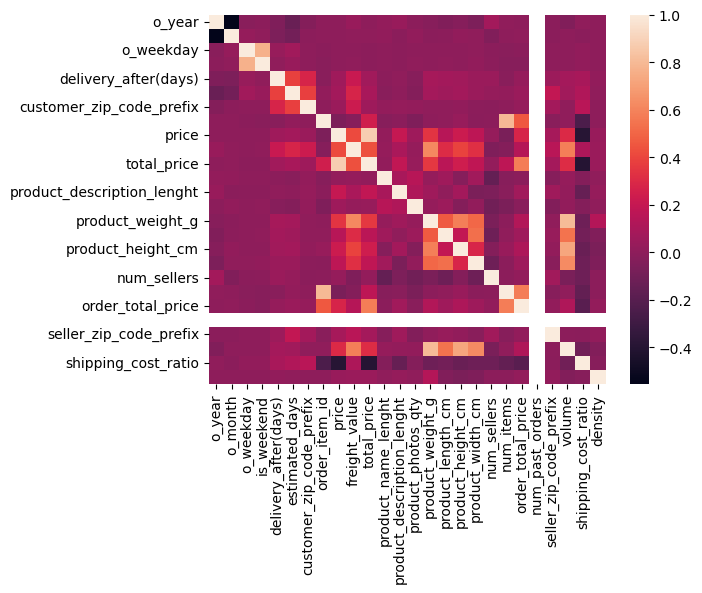

In [53]:
sns.heatmap(olist_df.corr(numeric_only=True))

In [54]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import xgboost as xgb

In [55]:
features = [
    'o_month', 'o_weekday', 'is_weekend', 'freight_value', 'num_items','volume',
    'product_weight_g','shipping_cost_ratio','density',
    'customer_zip_code_prefix','seller_zip_code_prefix','estimated_days'
]
target = 'delivery_after(days)'

X = olist_df[features]
y = olist_df[target]

numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()

preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', numerical_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ]
)

xgb_regressor = xgb.XGBRegressor(
    n_estimators=200,
    learning_rate=0.1, 
    max_depth=6, 
    subsample=0.8,  
    colsample_bytree=0.8,  
    random_state=42
)

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', xgb_regressor)
])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f'Mean Absolute Error: {mae}')
print(f'Mean Squared Error: {mse}')
print(f'R² Score: {r2}')



Mean Absolute Error: 4.844613930179354
Mean Squared Error: 61.50622658486682
R² Score: 0.3074528876682866


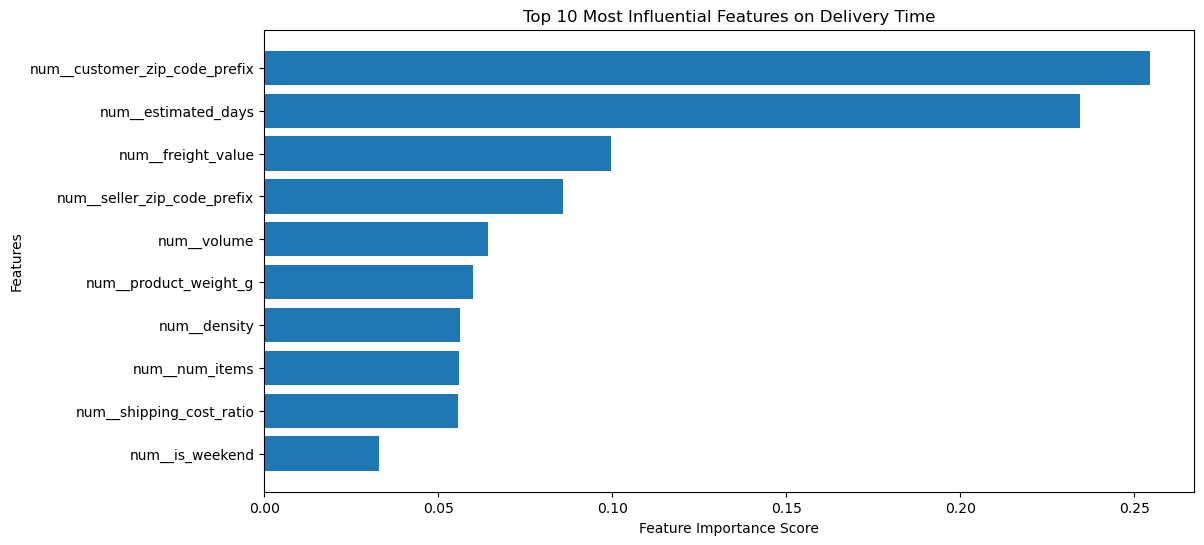

In [56]:
feature_importances = pipeline.named_steps['model'].feature_importances_

feature_names = pipeline.named_steps['preprocessor'].get_feature_names_out()

sorted_idx = np.argsort(feature_importances)[::-1] 
sorted_features = np.array(feature_names)[sorted_idx]
sorted_importances = feature_importances[sorted_idx]

plt.figure(figsize=(12, 6))
plt.barh(sorted_features[:10], sorted_importances[:10])  
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title('Top 10 Most Influential Features on Delivery Time')
plt.gca().invert_yaxis()  
plt.show()


In [59]:
new_order = pd.DataFrame([{
    'o_month': 4,
    'o_weekday': 2,
    'is_weekend': 0,  # 0 = Not weekend 1 = Weekend
    'freight_value': 15.0,
    'product_weight_g': 500,
    'num_sellers': 1,
    'num_items': 2,
    'total_price':39,
    'volume': 1567,
    'shipping_cost_ratio':88,
    'density':66,'customer_zip_code_prefix':3456,
    'seller_zip_code_prefix':345,
    'estimated_days':12,
    
    
}])

new_order['shipping_cost_ratio'] = new_order['freight_value'] / new_order['total_price']

new_order['density'] = new_order['product_weight_g'] / new_order['volume']

new_order = new_order[features]

predicted_days = pipeline.predict(new_order)[0]
print(f'Predicted Delivery Time: {predicted_days:.0f} days')


Predicted Delivery Time: 4 days


In [60]:

test_rows = olist_df.iloc[:5]  # Modify the number of rows as needed
X_test_t = test_rows[features]
y_test_t = test_rows[target]
estimated_days_t = test_rows['estimated_days']
y_pred_t = pipeline.predict(X_test_t)

error_t = abs(y_test_t - y_pred_t)
comparison_df_t = pd.DataFrame({
    'Actual': y_test_t,
    'Predicted': y_pred_t.round(),
    'Error': error_t.round(),
    'Estimated_Day': estimated_days_t,
})
comparison_df_t


,Actual,Predicted,Error,Estimated_Day
0,12.0,12.0,0.0,24
1,11.0,17.0,6.0,33
2,9.0,11.0,2.0,21
3,13.0,11.0,2.0,21
4,13.0,11.0,2.0,21


In [61]:
# from sklearn.metrics import accuracy_score

In [62]:
# logistic_model = LogisticRegression()

In [63]:
# # Feature Engineering: Add interaction terms
# olist_df['shipping_cost_ratio'] = olist_df['freight_value'] / olist_df['total_price']
# olist_df['density'] = olist_df['product_weight_g'] / olist_df['volume']
# olist_df['price_per_item'] = olist_df['price'] / (olist_df['num_items'] + 1)  # Avoid division by zero

# features = [
#     'o_year', 'o_month', 'o_weekday', 'is_weekend', 
#     'customer_zip_code_prefix', 'freight_value', 'seller_zip_code_prefix', 
#     'price', 'num_items', 'volume', 'shipping_cost_ratio', 'density', 'price_per_item'
# ]

# target = 'delivery_after(days)'

# X = olist_df[features]
# y = olist_df[target]

# # Identify numerical and categorical columns
# numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
# categorical_cols = X.select_dtypes(include=['object']).columns.tolist()

# # Data Preprocessing: Scale numerical data
# preprocessor = ColumnTransformer(
#     transformers=[
#         ('num', StandardScaler(), numerical_cols),
#         ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
#     ]
# )

# # Hyperparameter Tuning using GridSearchCV
# param_grid = {
#     'n_estimators': [100, 200, 300],
#     'learning_rate': [0.05, 0.1, 0.2],
#     'max_depth': [4, 6, 8],
#     'subsample': [0.7, 0.8, 0.9],
#     'colsample_bytree': [0.7, 0.8, 0.9]
# }

# xgb_regressor = xgb.XGBRegressor(random_state=42)

# grid_search = GridSearchCV(xgb_regressor, param_grid, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# pipeline = Pipeline(steps=[
#     ('preprocessor', preprocessor),
#     ('model', grid_search)
# ])

# pipeline.fit(X_train, y_train)

# best_params = grid_search.best_params_
# print("Best Parameters:", best_params)

# # Predictions
# y_pred = pipeline.predict(X_test)

# # Performance Evaluation

# r2 = r2_score(y_test, y_pred)
# mse = mean_squared_error(y_test, y_pred)
# print(f'Mean Squared Error: {mse:.2f}')
# print(f'R² Score: {r2:.2f}')


In [64]:
# train_features = ['r45545', 'Education', 'Gender']

# x_train = loan_train[train_features].values
# y_train = loan_train['Loan_Status'].values
# # 
# x_test = loan_test[train_features].values

In [65]:
# logistic_model.fit(x_train, y_train)

In [66]:
# predicted = logistic_model.predict(x_test)

In [67]:
# # check the coefficeints of the trained model
# print('Coefficient of model :', logistic_model.coef_)

In [68]:
# # check the intercept of the model
# print('Intercept of model',logistic_model.intercept_)

In [73]:
# # Accuray Score on train dataset
# # accuracy_train = accuracy_score(x_test, predicted)
# score = logistic_model.score(x_train, y_train)
# print('accuracy_score overall :', score)
# print('accuracy_score percent :', round(score*100,2))

In [74]:
# # predict the target on the test dataset
# predict_test = logistic_model.predict(x_test)
# print('Target on test data',predict_test) 

In [75]:

# ml = pd.get_dummies(olist_df, columns=["o_season", "product_category_name"], drop_first=True)

# X = ml[["o_year", "o_month", "o_weekday", "is_weekend", "order_total_price", "num_sellers"] +
#        [col for col in ml.columns if col.startswith("season_") or col.startswith("product_category_name_")]]
# y = ml["order_total_price"] 

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# xgb_model = xgb.XGBRegressor(n_estimators=300, learning_rate=0.05, max_depth=8, random_state=42)
# xgb_model.fit(X_train, y_train)

# y_pred = xgb_model.predict(X_test)

# mae = mean_absolute_error(y_test, y_pred)
# mse = mean_squared_error(y_test, y_pred)
# r2 = r2_score(y_test, y_pred)

# print(f"Mean Absolute Error (MAE): {mae:.2f}")
# print(f"Mean Squared Error (MSE): {mse:.2f}")
# print(f"R-squared (R²): {r2:.4f}")

In [76]:
# future_data = pd.DataFrame({"o_year": [2016], "o_month": [7], "o_weekday": [3],
#                             "is_weekend": [0], "num_past_orders": [5], "num_items": [3],
#                             "order_total_price": [150], "num_sellers": [2]})
# for col in X.columns:
#     if col not in future_data:
#         future_data[col] = 0

# future_sales = xgb_model.predict(future_data)
# print(f"Predicted Sales for July 2019: {future_sales[0]:.2f}")

# # plt.figure(figsize=(10, 5))
# sns.scatterplot(x=y_test, y=y_pred)
# plt.xlabel("Actual Sales")
# plt.ylabel("Predicted Sales")
# plt.title("Actual vs Predicted Sales (XGBoost Model)")
# plt.grid(True)
# plt.show()

In [77]:
# ml2 = pd.get_dummies(olist_df, columns=["season", "product_category_name"], drop_first=True)

# X = ml[["year", "month", "weekday", "is_weekend", "num_past_orders", "num_items", "order_total_price", "num_sellers"] +
#        [col for col in ml.columns if col.startswith("season_") or col.startswith("product_category_name_")]]
# y = ml["payment_value"] 

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# xgb_model = xgb.XGBRegressor(n_estimators=300, learning_rate=0.05, max_depth=8, random_state=42)
# xgb_model.fit(X_train, y_train)

# y_pred = xgb_model.predict(X_test)

# mae = mean_absolute_error(y_test, y_pred)
# mse = mean_squared_error(y_test, y_pred)
# r2 = r2_score(y_test, y_pred)

# print(f"Mean Absolute Error (MAE): {mae:.2f}")
# print(f"Mean Squared Error (MSE): {mse:.2f}")
# print(f"R-squared (R²): {r2:.4f}")